In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-05 19:55:43.286583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 19:55:43.304223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733428543.324070   12404 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733428543.330150   12404 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 19:55:43.350359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
!rm -rf clothing-dataset-small/
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 58.65 MiB/s, done.
Resolving deltas: 100% (10/10), done.


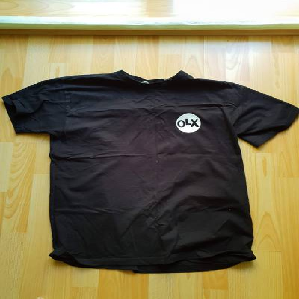

In [3]:
img = load_img('./clothing-dataset-small/train/t-shirt/5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg', target_size=(299, 299))
img

In [4]:
x = np.array(img)
x.shape

(299, 299, 3)

In [5]:
model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3)
)

I0000 00:00:1733428549.998176   12404 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [6]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [7]:
X = preprocess_input(X)
X.shape

(1, 299, 299, 3)

In [8]:
pred = model.predict(X)
pred.shape

I0000 00:00:1733428552.978112   12461 service.cc:148] XLA service 0x7f1350003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733428552.978144   12461 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-05 19:55:53.014064: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733428553.326951   12461 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-05 19:55:54.453191: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1733428555.286578   12461 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(1, 1000)

In [9]:
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.6819637)),
  ('n02916936', 'bulletproof_vest', np.float32(0.038139876)),
  ('n04370456', 'sweatshirt', np.float32(0.03432471)),
  ('n03710637', 'maillot', np.float32(0.011354204)),
  ('n04525038', 'velvet', np.float32(0.0018453564))]]

In [10]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train/', target_size=(150, 150), batch_size=32
)

Found 3068 images belonging to 10 classes.


In [12]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [13]:
X, y = next(train_ds)

In [14]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation/', target_size=(150, 150), batch_size=32, shuffle=False
)

Found 341 images belonging to 10 classes.


In [15]:
base_model = Xception(
    weights='imagenet', include_top=False, input_shape=(150, 150, 3)
)
base_model.trainable = False

In [16]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [17]:
preds = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [18]:
preds.shape

(32, 10)

In [19]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [20]:
model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])

In [21]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.5916 - loss: 1.6176 - val_accuracy: 0.7507 - val_loss: 1.0184
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8081 - loss: 0.5983 - val_accuracy: 0.7742 - val_loss: 0.9433
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8951 - loss: 0.3154 - val_accuracy: 0.8006 - val_loss: 0.8473
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9389 - loss: 0.1797 - val_accuracy: 0.7742 - val_loss: 1.0161
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9464 - loss: 0.1470 - val_accuracy: 0.7537 - val_loss: 0.9911
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9687 - loss: 0.1094 - val_accuracy: 0.8152 - val_loss: 0.8503
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9747 - loss: 0.0684 - val_accuracy: 0.7947 - val_loss: 0.9108
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9740 - loss: 0.0861 - val_accuracy: 0.8035 - val_loss: 

In [22]:
history.history

{'accuracy': [0.6802477240562439,
  0.7998695969581604,
  0.8930899500846863,
  0.928943932056427,
  0.9397001266479492,
  0.9608865976333618,
  0.9768579006195068,
  0.9749022126197815,
  0.9859843254089355,
  0.9928292036056519],
 'loss': [1.1977274417877197,
  0.6606301069259644,
  0.3149816691875458,
  0.20344002544879913,
  0.17002645134925842,
  0.11835619807243347,
  0.06695355474948883,
  0.08442877978086472,
  0.049815207719802856,
  0.03320847824215889],
 'val_accuracy': [0.7507331371307373,
  0.774193525314331,
  0.8005865216255188,
  0.774193525314331,
  0.7536656856536865,
  0.8152492642402649,
  0.7947214245796204,
  0.803519070148468,
  0.8005865216255188,
  0.8269794583320618],
 'val_loss': [1.018369197845459,
  0.9432579874992371,
  0.8472794890403748,
  1.0161497592926025,
  0.991126298904419,
  0.8503244519233704,
  0.9107551574707031,
  0.9487515091896057,
  0.9528012871742249,
  0.8951601982116699]}

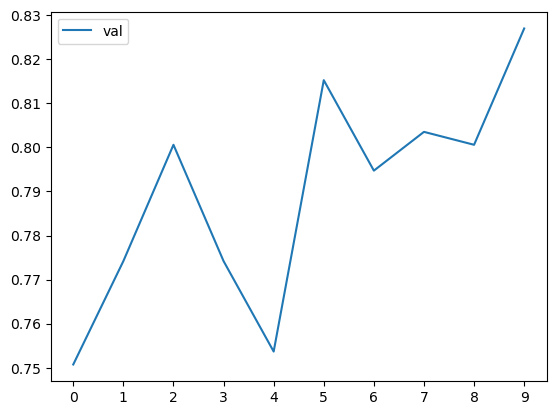

In [23]:
# plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [24]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
    weights='imagenet', include_top=False, input_shape=(150, 150, 3)
    )
    base_model.trainable = False
    ###########################################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(10)(inner)
    ###########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])
    return model

In [25]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f'Learning rate: {lr}')
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    print()

Learning rate: 0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.3801 - loss: 1.8883 - val_accuracy: 0.6334 - val_loss: 1.1211
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6697 - loss: 1.0107 - val_accuracy: 0.7302 - val_loss: 0.8297
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7354 - loss: 0.7942 - val_accuracy: 0.7595 - val_loss: 0.7304
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7906 - loss: 0.6524 - val_accuracy: 0.7889 - val_loss: 0.6733
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8199 - loss: 0.5678 - val_accuracy: 0.7947 - val_loss: 0.6395
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8446 - loss: 0.4925 - val_accuracy: 0.8152 - val_loss: 0.6040
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8569 - loss: 0.4566 - val_accuracy: 0.8065 - val_loss: 0.5933
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8848 - loss: 0.4205 - 

In [26]:
del scores[0.1]
del scores[0.0001]

In [27]:
scores

{0.001: {'accuracy': [0.6479791402816772,
   0.8177965879440308,
   0.8758148550987244,
   0.9097131490707397,
   0.942307710647583,
   0.9683833122253418,
   0.9781616926193237,
   0.9908735156059265,
   0.9970664978027344,
   0.9996740818023682],
  'loss': [1.0256351232528687,
   0.5292055010795593,
   0.37651339173316956,
   0.28687340021133423,
   0.20854288339614868,
   0.1414450705051422,
   0.10581391304731369,
   0.06894050538539886,
   0.04869925603270531,
   0.033589329570531845],
  'val_accuracy': [0.7712609767913818,
   0.8005865216255188,
   0.8181818127632141,
   0.8387096524238586,
   0.8152492642402649,
   0.8269794583320618,
   0.8152492642402649,
   0.8269794583320618,
   0.8181818127632141,
   0.8152492642402649],
  'val_loss': [0.6526145339012146,
   0.5573640465736389,
   0.5435007810592651,
   0.5168689489364624,
   0.5410358309745789,
   0.555239200592041,
   0.5914625525474548,
   0.578709602355957,
   0.6100835800170898,
   0.6145886182785034]},
 0.01: {'accura

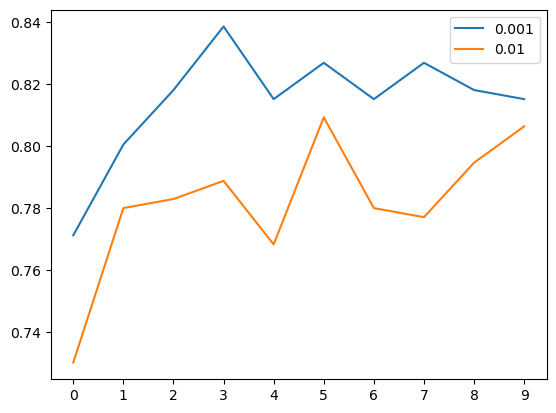

In [28]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend()

In [29]:
learning_rate = 0.001

In [30]:
model.save_weights('model_v1.weights.h5')

In [31]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [32]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.5464 - loss: 1.3594 - val_accuracy: 0.8006 - val_loss: 0.6409
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8160 - loss: 0.5260 - val_accuracy: 0.8035 - val_loss: 0.5814
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8888 - loss: 0.3479 - val_accuracy: 0.8035 - val_loss: 0.5690
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9216 - loss: 0.2694 - val_accuracy: 0.8065 - val_loss: 0.5898
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9564 - loss: 0.1829 - val_accuracy: 0.8299 - val_loss: 0.5529
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9749 - loss: 0.1242 - val_accuracy: 0.8358 - val_loss: 0.5855
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9844 - loss: 0.0934 - val_accuracy: 0.8240 - val_loss: 0.5691
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9910 - loss: 0.0668 - val_accuracy: 0.8270 -

In [33]:
learning_rate = 0.001
scores = {}
for size in [10, 100, 1000]:
    print(f'Inner layer size: {size}')
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    print()

Inner layer size: 10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.3562 - loss: 1.8523 - val_accuracy: 0.6833 - val_loss: 1.1104
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6768 - loss: 1.0420 - val_accuracy: 0.7419 - val_loss: 0.8765
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7457 - loss: 0.7873 - val_accuracy: 0.7742 - val_loss: 0.7554
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8105 - loss: 0.6064 - val_accuracy: 0.7830 - val_loss: 0.6933
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8370 - loss: 0.5103 - val_accuracy: 0.7918 - val_loss: 0.6490
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8468 - loss: 0.4620 - val_accuracy: 0.8182 - val_loss: 0.6245
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8784 - loss: 0.4279 - val_accuracy: 0.8182 - val_loss: 0.6039
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8924 - loss: 0.3643 - v

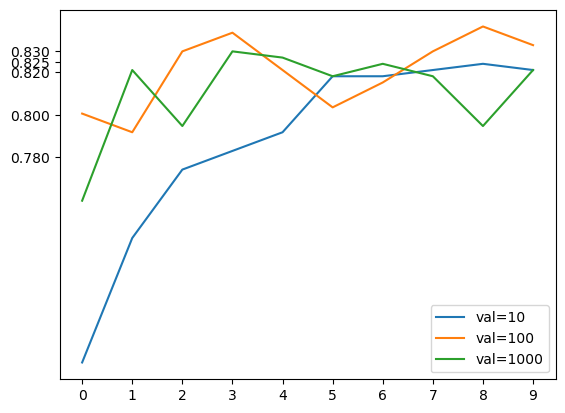

In [34]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'val={size}')
plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

In [35]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet', include_top=False, input_shape=(150, 150, 3)
    )
    base_model.trainable = False
    ###########################################
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    ###########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])
    return model

In [36]:
learning_rate = 0.001
size = 100

scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Droprate: {droprate}')
    model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history
    print()

Droprate: 0.0
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5886 - loss: 1.2775 - val_accuracy: 0.7977 - val_loss: 0.6283
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8063 - loss: 0.5460 - val_accuracy: 0.8065 - val_loss: 0.5793
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8884 - loss: 0.3442 - val_accuracy: 0.8240 - val_loss: 0.5203
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9187 - loss: 0.2692 - val_accuracy: 0.8240 - val_loss: 0.5637
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9492 - loss: 0.1872 - val_accuracy: 0.8035 - val_loss: 0.5812
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9656 - loss: 0.1488 - val_accuracy: 0.8387 - val_loss: 0.5512
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9877 - loss: 0.0894 - val_accuracy: 0.8270 - val_loss: 0.5703
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9950 - loss: 0.0670 - val_accu

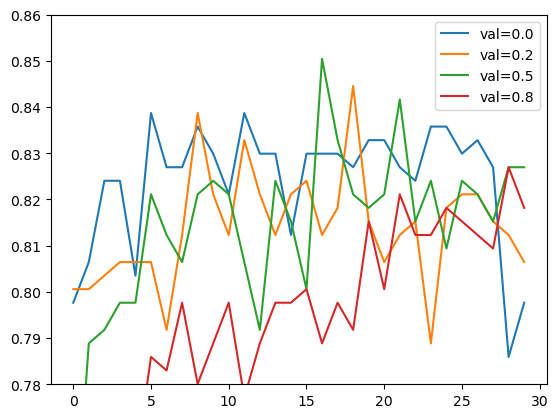

In [37]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'val={droprate}')
# plt.xticks(np.arange(10))
# plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.ylim(0.78, 0.86)
plt.legend()

In [38]:
learning_rate = 0.001
size_inner = 100
droprate = 0.2

In [39]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rotation_range=30,
    # width_shift_range=10.0,
    # height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True
)
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train/', target_size=(150, 150), batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation/', target_size=(150, 150), batch_size=32, shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [40]:
learning_rate = 0.001
size_inner = 100
droprate = 0.2
model = make_model(learning_rate=learning_rate, size_inner=size_inner, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.4817 - loss: 1.5339

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.4826 - loss: 1.5313 - val_accuracy: 0.7537 - val_loss: 0.7471
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.7019 - loss: 0.8816 - val_accuracy: 0.7654 - val_loss: 0.6902
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.7515 - loss: 0.7553 - val_accuracy: 0.7801 - val_loss: 0.6989
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.7708 - loss: 0.6977 - val_accuracy: 0.7771 - val_loss: 0.6541
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.7870 - loss: 0.6545 - val_accuracy: 0.8006 - val_loss: 0.6282
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.7968 - loss: 0.5981 - val_accuracy: 0.7859 - val_loss: 0.6821
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.8118 - loss: 0.5519 - val_accuracy: 0.7889 - val_loss: 0.6030
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.8273 - loss: 0.5085 - val_accuracy: 0.780

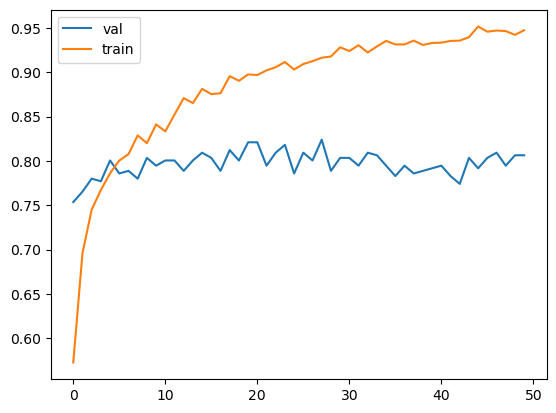

In [41]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend()

In [42]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3)
    )
    base_model.trainable = False
    ###########################################
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    ###########################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])
    return model

In [43]:
input_size = 299

In [44]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True
)
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train/', target_size=(input_size, input_size), batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation/', target_size=(input_size, input_size), batch_size=32, shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [45]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [46]:
learning_rate = 0.001
size_inner = 100
droprate = 0.2

model = make_model(input_size=input_size, learning_rate=learning_rate, size_inner=size_inner, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50


2024-12-05 20:34:26.100654: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


77/96 ━━━━━━━━━━━━━━━━━━━━ 10s 551ms/step - accuracy: 0.5237 - loss: 1.4639

2024-12-05 20:35:18.681272: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.5472 - loss: 1.3906

2024-12-05 20:35:40.909439: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 781ms/step - accuracy: 0.5483 - loss: 1.3872 - val_accuracy: 0.8123 - val_loss: 0.5671
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 580ms/step - accuracy: 0.7543 - loss: 0.7157 - val_accuracy: 0.8446 - val_loss: 0.4777
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 577ms/step - accuracy: 0.8209 - loss: 0.5631 - val_accuracy: 0.8358 - val_loss: 0.4743
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 585ms/step - accuracy: 0.8191 - loss: 0.5363 - val_accuracy: 0.8534 - val_loss: 0.4192
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.8280 - loss: 0.4910 - val_accuracy: 0.8651 - val_loss: 0.4048
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 573ms/step - accuracy: 0.8541 - loss: 0.4357 - val_accuracy: 0.8592 - val_loss: 0.4102
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 579ms/step - accuracy: 0.8751 - loss: 0.3727 - val_accuracy: 0.8710 - val_loss: 0.3986
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 571ms/step - accuracy: 0.8761 - loss: 0.3877 - val_accuracy: 0.844

In [48]:
trained_model = keras.models.load_model('xception_v4_36_0.883.keras')
input_size = 299
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test/', target_size=(input_size, input_size), batch_size=32, shuffle=False
)
trained_model.evaluate(test_ds)

Found 372 images belonging to 10 classes.


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8773 - loss: 0.3720

2024-12-05 21:22:45.848649: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 852ms/step - accuracy: 0.8808 - loss: 0.3603


[0.29632702469825745, 0.9005376100540161]

In [50]:
path = './clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(input_size, input_size))
x = np.array(img)
X = np.array([x])
# print(X.shape)
X = preprocess_input(X)
pred = trained_model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [51]:
classes = ['dress','hat','longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']

In [52]:
dict(zip(classes, pred[0]))

{'dress': np.float32(-4.2207394),
 'hat': np.float32(-5.5019174),
 'longsleeve': np.float32(-2.1719253),
 'outwear': np.float32(-4.5228167),
 'pants': np.float32(9.787269),
 'shirt': np.float32(-4.13163),
 'shoes': np.float32(-4.819027),
 'shorts': np.float32(5.424452),
 'skirt': np.float32(-3.083747),
 't-shirt': np.float32(-5.8143334)}